In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import chromadb
import json
import pandas as pd
import matplotlib.pyplot as plt
#from chromadb.utils.data_loaders import ImageLoader
from weavingtools.embedding_tools import SigLIPEmbedder, ImageLoaderRGB
from weavingtools.linkage_tools import plot_query_results
import scipy.spatial as sp
import seaborn as sns
import numpy as np
sns.set()

In [3]:
checkpoint = 'google/siglip-base-patch16-224'

siglip_embedder = SigLIPEmbedder(checkpoint)

client = chromadb.PersistentClient(path="hw")

data_loader = ImageLoaderRGB()

collection_db = client.get_or_create_collection(name="heritage_weaver", 
                                             metadata={"hnsw:space": "cosine"},
                                             embedding_function=siglip_embedder, 
                                             data_loader=data_loader
                                            )

# Check database

In [4]:
collection_df = pd.read_csv('data/heritage_weaver_data.csv')

In [5]:
collection_df.shape[0], collection_db.count()

(28475, 97587)

# Compare a pair of items across modalities

In [6]:
data = collection_db.get()# where={'collection':'smg'}

In [7]:
#idx1, idx2 = 100, 8003

In [8]:
rids = [record['record_id'] for record in data['metadatas']]
ids = data['ids']
r1 = collection_db.get(where={'record_id':'co8427235'},include=['embeddings','metadatas'])
r2 = collection_db.get(where={'record_id':'T.1909.5.2'},include=['embeddings','metadatas'])
im_1 = [r['modality'] for r in r1['metadatas']]
im_2 = [r['modality'] for r in r2['metadatas']]
sent_1 = [r.get('sentence','image') for r in r1['metadatas']]
sent_2 = [r.get('sentence','image') for r in r2['metadatas']]
r1_emb = np.matrix(r1['embeddings'])
r2_emb = np.matrix(r2['embeddings'])
mult = 1 - sp.distance.cdist(r1_emb,r2_emb, 'cosine')

In [9]:
similiarities = list(zip(*np.where(mult > 0.8)))
[(sent_1[i], sent_2[j], mult[i,j]) for i,j in similiarities]

[('image', 'image', 0.8283044526048334),
 ('image', 'image', 0.8283044526048334),
 ('image', 'image', 0.8015054662549996),
 ('image', 'image', 0.8015054662549996),
 ('image', 'image', 0.8591663008424422),
 ('image', 'image', 0.8591663008424422),
 ('image', 'image', 0.8361921059341751),
 ('image', 'image', 0.8361921059341751),
 ('image', 'image', 0.8360859108195355),
 ('image', 'image', 0.8360859108195355),
 ('image', 'image', 0.837479732745432),
 ('image', 'image', 0.837479732745432),
 ("Hughes' printing telegraph, 1860..\n\nHughes typewriting telegraph instrument, unknown maker, 1860.",
  'One of a collection of telegraph and telephone apparatus and materials - an early form of ink writer',
  0.8254143214826413),
 ('Hughes typewriting telegraph instrument, 1860, invented about 1855 by David Edward Hughes (), patent number 938, 1858.',
  'One of a collection of telegraph and telephone apparatus and materials - an early form of ink writer',
  0.8259127628714884),
 ('Hughes typewriting t

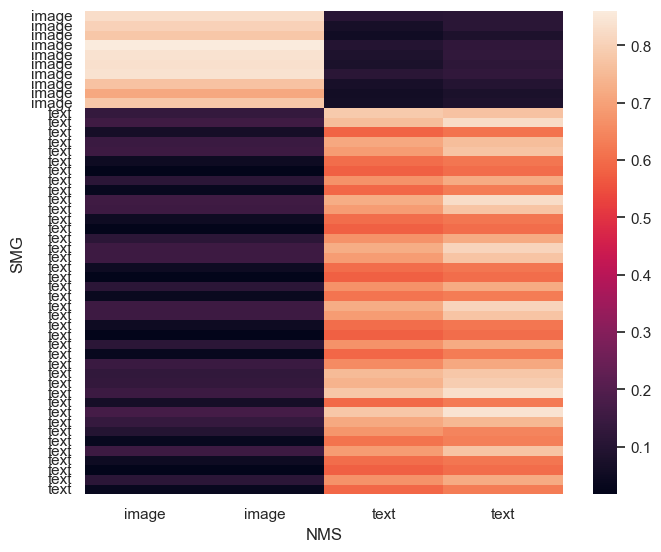

In [10]:
sns.set(rc={'figure.figsize':(7.7,6.27)})
ax = sns.heatmap(mult, yticklabels=im_1, xticklabels=im_2)
ax.set(xlabel='NMS', ylabel='SMG')
plt.show()

# Collection Level Comparison

In [22]:
from weavingtools.linkage_tools import compute_similarities, get_edges, get_data
from weavingtools.annotation_tools import *
from weavingtools.embedding_tools import *
from tqdm.notebook import tqdm
import networkx as nx

In [13]:
def plot_record_pairs(record_pairs):
    fig, axes = plt.subplots(len(record_pairs), 2, figsize=(15, 15.5))
    
    for j in range(len(record_pairs)):
        for i in range(2):
            record = collection_df[collection_df.record_id==record_pairs[j][i]]
            img_path = record.img_path.values[0]
            description = soft_wrap_text( record.description.values[0]) # record.record_id.values[0] + ' '  +
            img = Image.open(img_path)
            axes[j,i].imshow(img)
            #axes[j,i].set_title(record.record_id.values[0], fontsize = 10)
            axes[j,i].set_title(description[:50], fontsize = 10)
            axes[j,i].axis('off')
         
    plt.show()



In [14]:
coll1, coll2 = 'smg','nms'
modality1, modality2 = 'text','text' #'image', 'image' #
agg_func = 'max' # mean or max
percentile = 99.9  #99.95 | False
threshold = 0.8
tt_edges, tt_similarities, tt_inputs = get_edges(collection_db,coll1,coll2, modality1, modality2, agg_func, percentile, threshold,); len(tt_edges)


Get inputs...
7 7
Compute similarities...
--- Get similarities ---
--- Using 0.8710757399969417 as threshold ---
--- Aggregate similarities by record ---
--- Threshold similarities and binarize ---
Retrieve edges...


65744

In [15]:
coll1, coll2 = 'smg','nms'
modality1, modality2 = 'image','image' #'image', 'image' #
agg_func = 'max' # mean or max
percentile = 99.75  #99.95 | False
threshold = 0.8
ii_edges, ii_similarities, ii_inputs = get_edges(collection_db,coll1,coll2, modality1, modality2, agg_func,percentile, threshold ); len(ii_edges)


Get inputs...
7 7
Compute similarities...
--- Get similarities ---
--- Using 0.8072915220303836 as threshold ---
--- Aggregate similarities by record ---
--- Threshold similarities and binarize ---
Retrieve edges...


28854

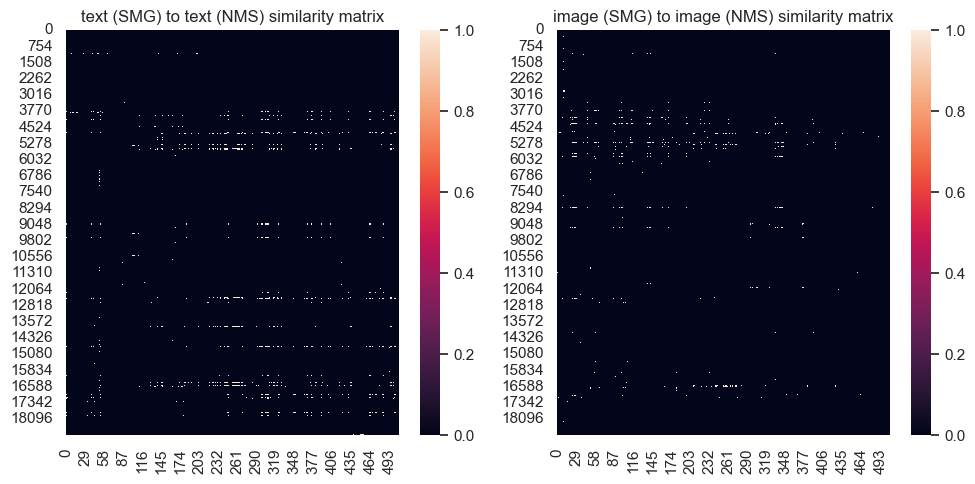

In [16]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first matrix
sns.heatmap(tt_similarities, ax=axs[0]) # , annot=True, cbar=False
axs[0].set_title('text (SMG) to text (NMS) similarity matrix')

# Plot the second matrix
sns.heatmap(ii_similarities, ax=axs[1]) # , annot=True, cbar=False
axs[1].set_title('image (SMG) to image (NMS) similarity matrix')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
def overlapping_edges(edges1, edges2):
    return [e for e in edges1 if e in edges2]

overlap = overlapping_edges(tt_edges, ii_edges)

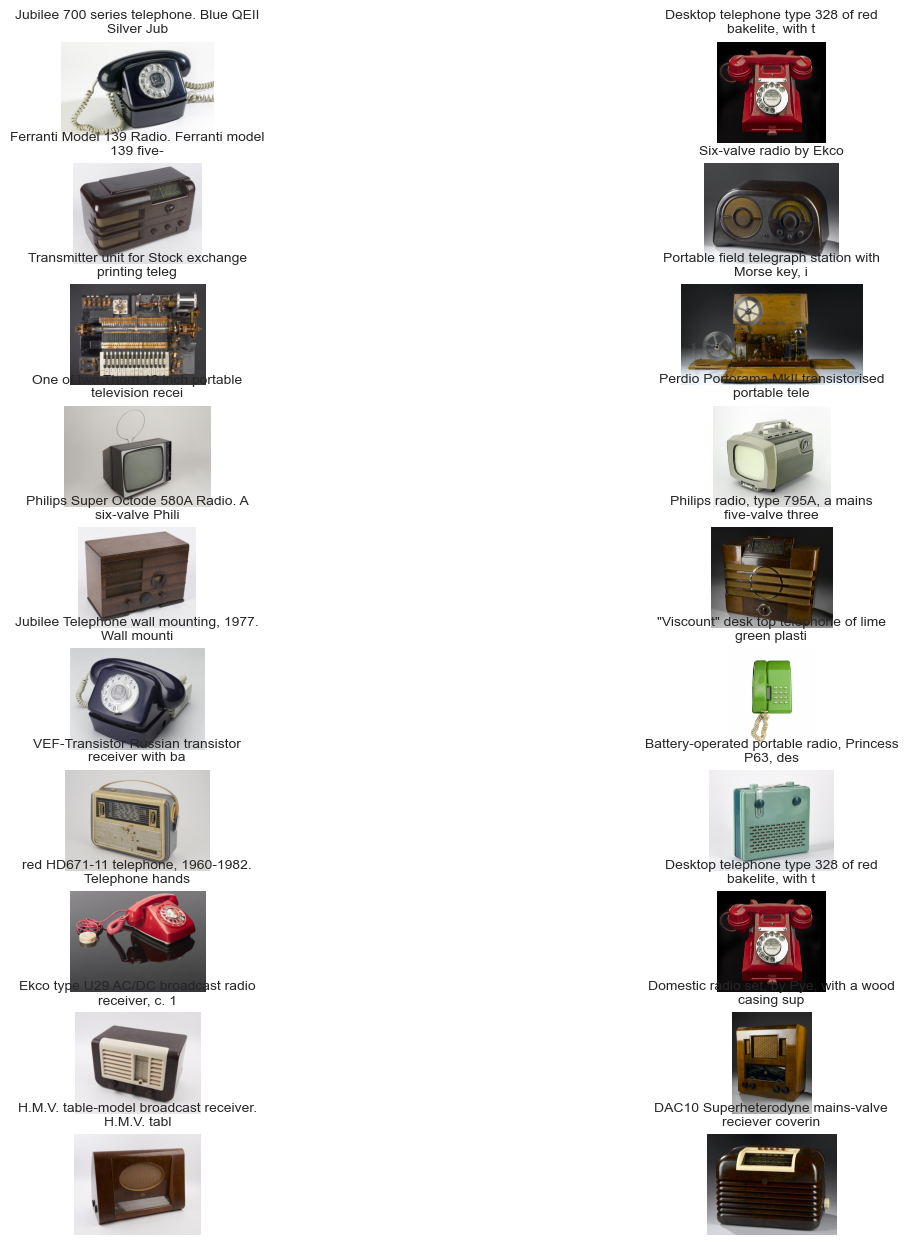

In [20]:
import random
random.shuffle(overlap)
plot_record_pairs(overlap[:10])

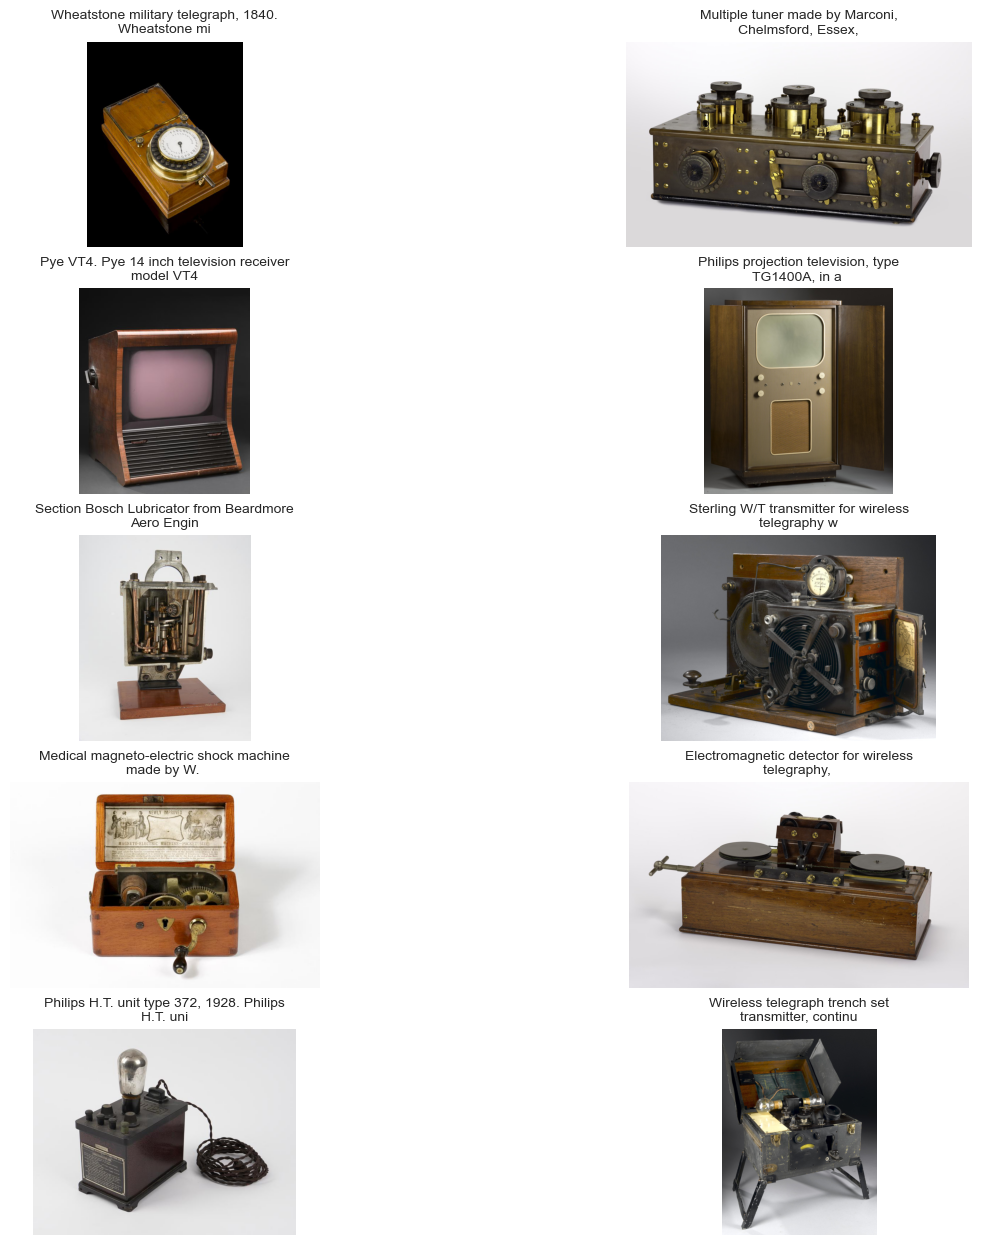

In [21]:
random.shuffle(ii_edges)
record_pairs = list(ii_edges)[:5]
plot_record_pairs(record_pairs)